# mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls drive

MyDrive


In [3]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [4]:
! ls

 knowledge_distillation
 mind_dataset
 mind_news_data_process.ipynb
'mind_news_knowledge_distillation _category.ipynb'
 mind_news_knowledge_distillation_ctr.ipynb
 README.md
 restricted_boltzmann_machines_movie_recommendation.ipynb
 wip_jupyter_notebooks


# Install transformer

https://huggingface.co/transformers/installation.html

In [5]:
! pip install transformers
# ! pip install sentencepiece

# Import modules

In [6]:
import os
import re
import time
import random
from glob import glob
import zipfile
import pickle
from pprint import pprint

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from sklearn import metrics
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from wordcloud import WordCloud

import torch
from torch import nn
import torch.nn.functional as F
import torchtext
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

%load_ext autoreload
%autoreload 2

In [7]:
# train and validate (instead of test) datasets are used here.
data_path_train = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/"
data_path_test = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/"
filename_train = data_path_train + "news_click_df.csv"
filename_test = data_path_test + "news_click_df.csv"
select_text_flag = "title"
select_label_flag = "category_flag" # category_flag # click_prob_flag
model_path = "/content/drive/MyDrive/Colab Notebooks/recommendation_systems/knowledge_distillation/trained_models/"

## set up environment

In [8]:
cd /content/drive/MyDrive/Colab Notebooks/recommendation_systems

/content/drive/MyDrive/Colab Notebooks/recommendation_systems


In [9]:
ls knowledge_distillation/

data_process.py      model_evaluation.py  __pycache__/
__init__.py          model_kd.py          set_up_environment.py
model_distilbert.py  model_lstm.py        trained_models/
model_doc2vec.py     model_word2vec.py


In [10]:
from knowledge_distillation.set_up_environment import set_random_seed, set_up_gpu

In [11]:
set_random_seed(999)
# device = set_up_gpu()
# print(device)

In [12]:
# Clear memory
# with torch.cuda.device('cuda:0'):
#     torch.cuda.empty_cache()

# Set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      

In [13]:
import torch
torch.backends.cudnn.enabled=False

# process data

In [14]:
from knowledge_distillation.data_process import DataProcessing

In [15]:
dp = DataProcessing()
data_df_train = dp.get_data(data_path_train, select_text_flag, select_label_flag)
data_df_test = dp.get_data(data_path_test, select_text_flag, select_label_flag)

0    32812
1       23
Name: click_prob_flag, dtype: int64
1    32020
0      815
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,8,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N107267,sports,football_nfl,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds","Good morning, Eagles fans. Is everybody OK? I know it's been a tough couple days for you all, first with the Eagles' rough 22-14 win over the Chicago Bears and then with the news that the team's most potent deep threat, DeSean Jackson, will likely be out for the season after reinjuring himself during the four snaps he played on Sunday. But hey, it's the bye week. So if you want to use this ...",https://assets.msn.com/labs/mind/AAJWD4e.html,"[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [3], ""SurfaceForms"": [""Eagles""]}]","[{""Label"": ""Philadelphia Eagles"", ""Type"": ""O"", ""WikidataId"": ""Q219714"", ""Confidence"": 0.93, ""OccurrenceOffsets"": [14, 109], ""SurfaceForms"": [""Eagles"", ""Eagles""]}, {""Label"": ""DeSean Jackson"", ""Type"": ""P"", ""WikidataId"": ""Q984336"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [220], ""SurfaceForms"": [""DeSean Jackson""]}, {""Label"": ""Chicago Bears"", ""Type"": ""O"", ""WikidataId"": ""Q205033"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [142], ""SurfaceForms"": [""Chicago Bears""]}]",NaN,NaN,0.0,0,1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


0    22252
1        4
Name: click_prob_flag, dtype: int64
1    21579
0      677
Name: category_flag, dtype: int64


,Unnamed: 0,id,category,subcategory,title,abstract,url,title_entities,abstract_entities,click,non_click,click_prob,click_prob_flag,category_flag,text,label
0,7,N124534,sports,football_nfl,Should NFL be able to fine players for criticizing officiating?,Several fines came down against NFL players for criticizing officiating this week. It's a very bad look for the league.,https://assets.msn.com/labs/mind/AAJ4lap.html,"[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [7], ""SurfaceForms"": [""NFL""]}]","[{""Label"": ""National Football League"", ""Type"": ""O"", ""WikidataId"": ""Q1215884"", ""Confidence"": 1.0, ""OccurrenceOffsets"": [32], ""SurfaceForms"": [""NFL""]}]",NaN,NaN,0.0,0,1,Should NFL be able to fine players for criticizing officiating?,1
1,18,N117551,sports,football_nfl,"Rye football wins 2019 rendition of The Game, clobbers Harrison","After going into halftime tied, the Garnets regrouped and made a resounding second-half statement in The Game.",https://assets.msn.com/labs/mind/AAIGv0N.html,[],[],NaN,NaN,0.0,0,1,"Rye football wins 2019 rendition of The Game, clobbers Harrison",1


In [16]:
select_col = ["text","label"]
num_classes = len(data_df_train["label"].unique())
print("num_classes", num_classes)

select_data_df_train = dp.select_data(data_df_train, select_col, decrease_fold=1)
select_data_df_test = dp.select_data(data_df_test, select_col, decrease_fold=1)
select_data_df_train.head(2)

num_classes 2
1    32020
0      815
Name: label, dtype: int64
1    21579
0      677
Name: label, dtype: int64


,text,label
0,Should NFL be able to fine players for criticizing officiating?,1
1,"As Eagles take their bye, a look at how the defense has improved lately | Early Birds",1


In [17]:
select_data_df_train, select_data_df_test = dp.clean_data(select_data_df_train, select_data_df_test)

dp.save_data_to_csv(select_data_df_train, data_path_train, select_columns=["text_clean","label"])
dp.save_data_to_csv(select_data_df_test, data_path_test, select_columns=["text_clean","label"])

filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_train/news_click_df.csv
1    32020
0      815
Name: label, dtype: int64
filename_ /content/drive/MyDrive/Colab Notebooks/recommendation_systems/mind_dataset/MINDlarge_dev/news_click_df.csv
1    21579
0      677
Name: label, dtype: int64


# generate models

In [18]:
from knowledge_distillation.model_doc2vec import Doc2vecModelling, Doc2vecModelPrediction
from knowledge_distillation.model_distilbert import DistilBERTModelling
from knowledge_distillation.model_word2vec import Word2vecModelling
from knowledge_distillation.model_lstm import LstmModelling
from knowledge_distillation.model_kd import KnowledgeDistillationModelling
from knowledge_distillation.model_evaluation import plot_confusion_matrix_heatmap

In [19]:
# set up parameters
num_epochs = 10
batch_size = 32

In [20]:
kd = KnowledgeDistillationModelling
dv = Doc2vecModelling
db = DistilBERTModelling
lm = LstmModelling
wv = Word2vecModelling

# knowledge distillation

In [21]:
token_name = "distilbert"
tokenizer  = db.get_tokenizer("distilbert-base-uncased")
train_iter_kd, test_iter_kd = db.process_text(tokenizer, 
                                              filename_train, filename_test, batch_size)

# train_iter_kd, test_iter_kd = lm.process_text(filename_train, filename_test, batch_size)

Size of TEXT vocabulary: 462207
Size of LABEL vocabulary: 3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model_name:  distilbert
token_name:  distilbert
epoch:  0 	 loss:  41.233909138536546
epoch:  1 	 loss:  20.238516087280004
epoch:  2 	 loss:  10.810370614603016
epoch:  3 	 loss:  3.7547953355889376
epoch:  4 	 loss:  2.411210613529107
epoch:  5 	 loss:  1.5876482661255054
epoch:  6 	 loss:  0.8106771929323529
epoch:  7 	 loss:  1.610873374757265
epoch:  8 	 loss:  1.592419509686117
epoch:  9 	 loss:  1.096441286086666
time :  226.7707142829895
time :  16.491034269332886
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       816
           1       1.00      1.00      1.00     32019

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999086340794884
Precision: 0.9999087077736848
Recall: 0.9999086340794884
F1 Score: 0.9999086613752993


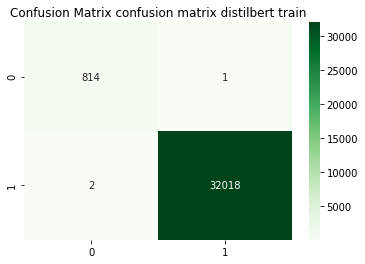

precision_score 0.9999672201461997
roc_auc_score-auc: 0.9993552725865353
roc_curve-fpr: [0.         0.00122699 1.        ]
roc_curve-tpr: [0.         0.99993754 1.        ]


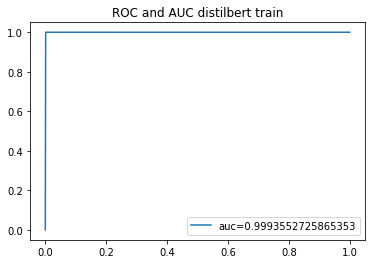

time :  11.042060375213623
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       680
           1       1.00      1.00      1.00     21576

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9997753414809489
Precision: 0.999776128145913
Recall: 0.9997753414809489
F1 Score: 0.9997755820050962


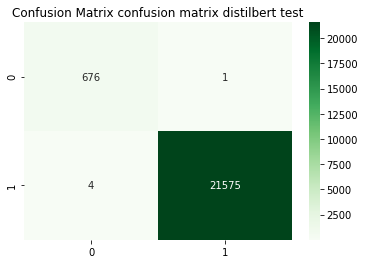

precision_score 0.9999480222111254
roc_auc_score-auc: 0.9991687648620031
roc_curve-fpr: [0.        0.0014771 1.       ]
roc_curve-tpr: [0.         0.99981463 1.        ]


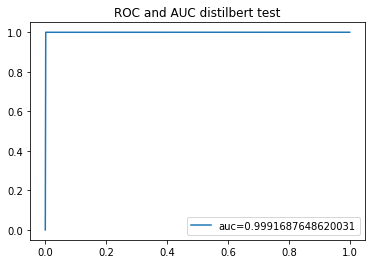

In [22]:
distilbert_model2 = db.generate_model(num_classes)
distilbert_model2, device = kd.train(distilbert_model2, device, 
                                    train_iter_kd, "distilbert", token_name, 
                                    num_classes, num_epochs, model_path)

kd.predict(distilbert_model2, device, train_iter_kd, token_name, "distilbert train", num_classes)
kd.predict(distilbert_model2, device, test_iter_kd, token_name, "distilbert test", num_classes)

LSTMModel(
  (embedding): Embedding(30000, 128)
  (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
model_name:  lstm
token_name:  distilbert
epoch:  0 	 loss:  97.18432508362457
epoch:  1 	 loss:  24.844734350743238
epoch:  2 	 loss:  6.591578965715598
epoch:  3 	 loss:  3.385682803917007
epoch:  4 	 loss:  2.002158142735425
epoch:  5 	 loss:  1.3155981709824118
epoch:  6 	 loss:  1.2377173194090574
epoch:  7 	 loss:  1.0372171470717149
epoch:  8 	 loss:  0.76617551352183
epoch:  9 	 loss:  0.19876899701398543
time :  97.0141716003418
time :  2.4338152408599854
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       817
           1       1.00      1.00      1.00     32018

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.999

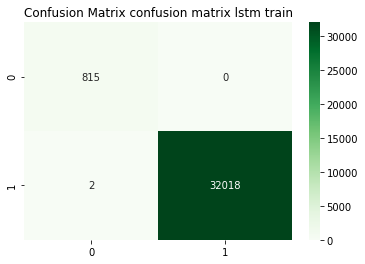

precision_score 0.9999984496517756
roc_auc_score-auc: 0.9999687695190507
roc_curve-fpr: [0. 0. 1.]
roc_curve-tpr: [0.         0.99993754 1.        ]


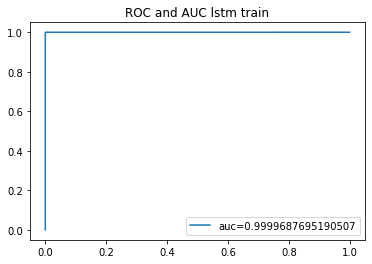

time :  1.5711266994476318
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       678
           1       1.00      1.00      1.00     21578

    accuracy                           1.00     22256
   macro avg       1.00      0.99      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9994158878504673
Precision: 0.9994163392533605
Recall: 0.9994158878504673
F1 Score: 0.9994160966227127


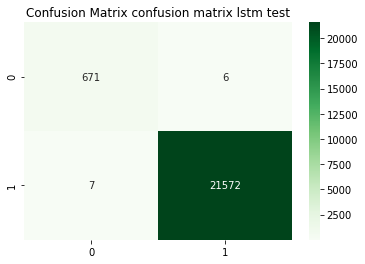

precision_score 0.9997121616859712
roc_auc_score-auc: 0.9954064906503074
roc_curve-fpr: [0.         0.00886263 1.        ]
roc_curve-tpr: [0.         0.99967561 1.        ]


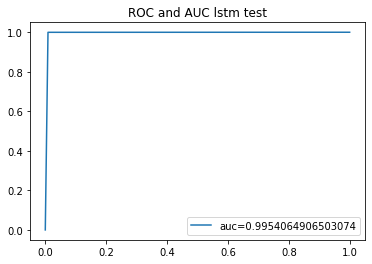

In [23]:
lstm_model2 = lm.generate_model(num_classes)
lstm_model2, device = kd.train(lstm_model2, device, train_iter_kd, 
                                  "lstm", token_name, num_classes, num_epochs, model_path)
kd.predict(lstm_model2, device, train_iter_kd, token_name, "lstm train", num_classes)
kd.predict(lstm_model2, device, test_iter_kd, token_name, "lstm test", num_classes)

2 30000
EmbeddingBagModel(
  (embedding): EmbeddingBag(30000, 128, mode=mean)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
model_name:  glove
token_name:  distilbert
epoch:  0 	 loss:  116.97753969952464
epoch:  1 	 loss:  27.73751542138052
epoch:  2 	 loss:  9.482049765007105
epoch:  3 	 loss:  4.060498186612676
epoch:  4 	 loss:  1.8507360786625213
epoch:  5 	 loss:  0.9440426219152869
epoch:  6 	 loss:  0.5833020325566167
epoch:  7 	 loss:  0.4208522947857709
epoch:  8 	 loss:  0.3224745923307353
epoch:  9 	 loss:  0.2961241030435531
time :  34.233933448791504
time :  1.1638195514678955
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       817
           1       1.00      1.00      1.00     32018

    accuracy                           1.00     32835
   macro avg       1.00      1.00      1.00     32835
weighted avg       1.00      1.00      1.00     32835

predicted label:  {0, 1}
Accuracy: 0.9999390893863256
Pr

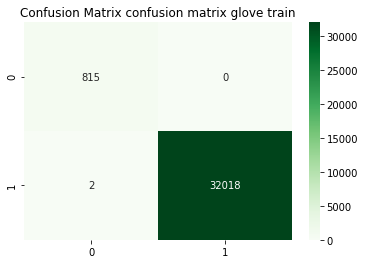

precision_score 0.9999984496517756
roc_auc_score-auc: 0.9999687695190507
roc_curve-fpr: [0. 0. 1.]
roc_curve-tpr: [0.         0.99993754 1.        ]


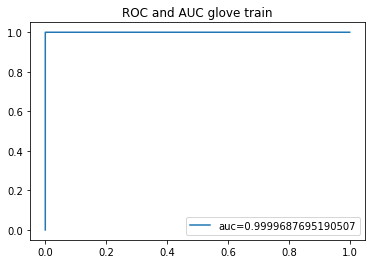

time :  0.7767167091369629
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       675
           1       1.00      1.00      1.00     21581

    accuracy                           1.00     22256
   macro avg       1.00      1.00      1.00     22256
weighted avg       1.00      1.00      1.00     22256

predicted label:  {0, 1}
Accuracy: 0.9995506829618979
Precision: 0.9995501754220354
Recall: 0.9995506829618979
F1 Score: 0.9995503610373072


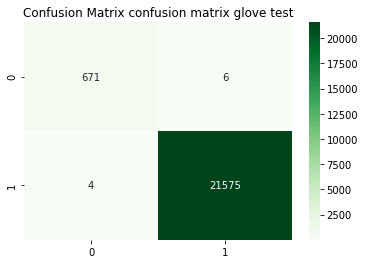

precision_score 0.9997163906149539
roc_auc_score-auc: 0.9954760026758879
roc_curve-fpr: [0.         0.00886263 1.        ]
roc_curve-tpr: [0.         0.99981463 1.        ]


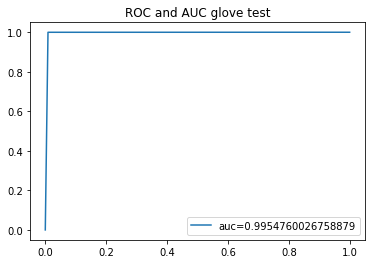

In [24]:
glove_model2 = wv.generate_model(num_classes)

glove_model2, device = kd.train(glove_model2, device, train_iter_kd, 
                                "glove", token_name, num_classes, num_epochs, model_path)
kd.predict(glove_model2, device, train_iter_kd, token_name, "glove train", num_classes)
kd.predict(glove_model2, device, test_iter_kd, token_name, "glove test", num_classes)

In [25]:
# student models
student_model = glove_model2

# teacher models
teachers = [lstm_model2, distilbert_model2]
teachers_name = ["lstm", "distilbert"]

# teachers = [distilbert_model, lstm_model, glove_model]
teacher_models = []
for idx, te_model in enumerate(teachers):
    # print(te_model)
    te_model.load_state_dict(torch.load(model_path + teachers_name[idx] + '.pth'))
    te_model#.to(device)
    # te_model.eval()  # eval mode
    teacher_models.append(te_model)
teacher_models

[LSTMModel(
   (embedding): Embedding(30000, 128)
   (lstm): LSTM(128, 16, num_layers=2, batch_first=True)
   (fc): Linear(in_features=32, out_features=2, bias=True)
 ), DistilBERTClassifierNetwork(
   (distil_bert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0): TransformerBlock(
           (attention): MultiHeadSelfAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=Tr

epoch:  0 	 loss:  775.0456122606993
epoch:  1 	 loss:  580.7938312739134
epoch:  2 	 loss:  550.9221105277538
epoch:  3 	 loss:  527.1481942906976
epoch:  4 	 loss:  511.0942028015852
epoch:  5 	 loss:  486.3415881097317
epoch:  6 	 loss:  473.40298058092594
epoch:  7 	 loss:  453.5088025778532
epoch:  8 	 loss:  439.2100360393524
epoch:  9 	 loss:  429.11160097271204
time :  194.10542035102844
time :  1.2293238639831543
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       479
           1       1.00      0.99      0.99     32356

    accuracy                           0.99     32835
   macro avg       0.79      0.99      0.87     32835
weighted avg       0.99      0.99      0.99     32835

predicted label:  {0, 1}
Accuracy: 0.9897670169026953
Precision: 0.9898732810367259
Recall: 0.9897670169026953
F1 Score: 0.988465173555906


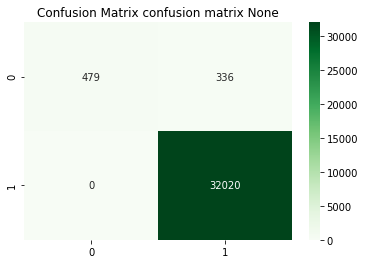

precision_score 0.989615527259241
roc_auc_score-auc: 0.7938650306748466
roc_curve-fpr: [0.         0.41226994 1.        ]
roc_curve-tpr: [0. 1. 1.]


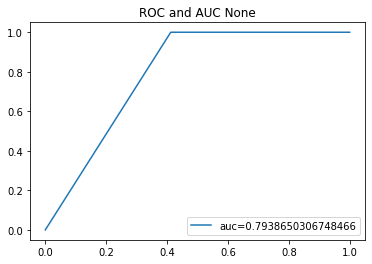

time :  0.7277278900146484
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       416
           1       1.00      0.99      0.99     21840

    accuracy                           0.99     22256
   macro avg       0.81      0.99      0.88     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.9881829618979152
Precision: 0.9882954547137802
Recall: 0.9881829618979152
F1 Score: 0.9868075702069647


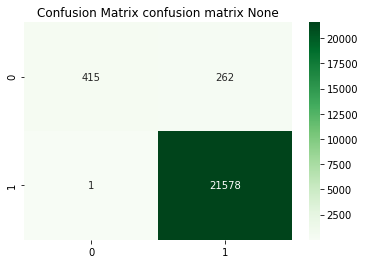

precision_score 0.9880028092835424
roc_auc_score-auc: 0.8064760907723694
roc_curve-fpr: [0.         0.38700148 1.        ]
roc_curve-tpr: [0.         0.99995366 1.        ]


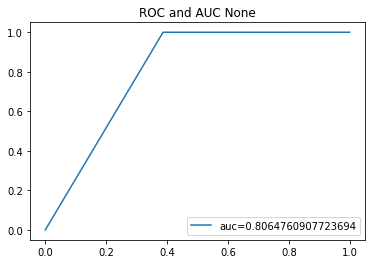

In [26]:
trained_student_model, device = kd.train_multi_teachers_kd(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, num_epochs, model_path, "kd")
kd.predict(trained_student_model, device, train_iter_kd, "distilbert", None, num_classes)
kd.predict(trained_student_model, device, test_iter_kd, "distilbert", None, num_classes)

temp:20.0, lr:0.0001
epoch:  0 	 loss:  415.6931511312723
epoch:  1 	 loss:  414.6404518187046
epoch:  2 	 loss:  414.17567617446184
epoch:  3 	 loss:  414.46104319393635
epoch:  4 	 loss:  413.7998955324292
epoch:  5 	 loss:  413.492375575006
epoch:  6 	 loss:  414.47255899757147
epoch:  7 	 loss:  412.9478036388755
epoch:  8 	 loss:  413.31193366646767
epoch:  9 	 loss:  412.9391537234187
time :  194.21589756011963
time :  1.2243990898132324
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       454
           1       1.00      0.99      0.99     32381

    accuracy                           0.99     32835
   macro avg       0.78      0.99      0.85     32835
weighted avg       0.99      0.99      0.99     32835

predicted label:  {0, 1}
Accuracy: 0.9890056342317649
Precision: 0.9891282050616446
Recall: 0.9890056342317649
F1 Score: 0.9874726322994853


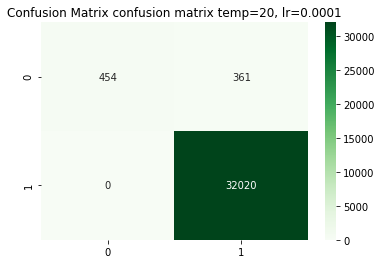

precision_score 0.9888514869831074
roc_auc_score-auc: 0.7785276073619631
roc_curve-fpr: [0.         0.44294479 1.        ]
roc_curve-tpr: [0. 1. 1.]


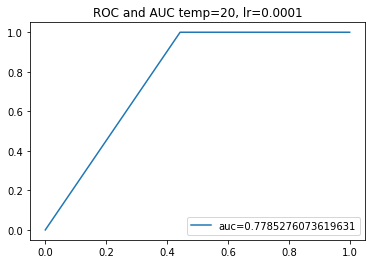

time :  0.7619822025299072
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       396
           1       1.00      0.99      0.99     21860

    accuracy                           0.99     22256
   macro avg       0.79      0.99      0.86     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.987284327821711
Precision: 0.9874153208648263
Recall: 0.987284327821711
F1 Score: 0.9856604491859632


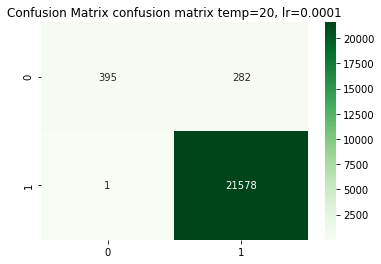

precision_score 0.9870989136956378
roc_auc_score-auc: 0.7917050420279085
roc_curve-fpr: [0.         0.41654357 1.        ]
roc_curve-tpr: [0.         0.99995366 1.        ]


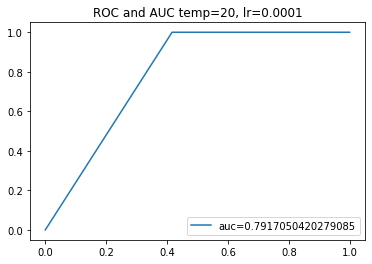

In [27]:
trained_student_model_t20, device = kd.train_multi_teachers_kd_param(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, num_epochs, model_path, "kd",
                                                20.0, 0.0001)
kd.predict(trained_student_model_t20, device, train_iter_kd, "distilbert", "temp=20, lr=0.0001", num_classes)
kd.predict(trained_student_model_t20, device, test_iter_kd, "distilbert", "temp=20, lr=0.0001", num_classes)

temp:1.0, lr:0.0001
epoch:  0 	 loss:  23.677996361244823
epoch:  1 	 loss:  22.680558034035812
epoch:  2 	 loss:  21.72793471513762
epoch:  3 	 loss:  21.52531635569858
epoch:  4 	 loss:  20.885035001677693
epoch:  5 	 loss:  20.163259325471927
epoch:  6 	 loss:  19.58576103864516
epoch:  7 	 loss:  19.417325822357043
epoch:  8 	 loss:  18.152483347012776
epoch:  9 	 loss:  17.493834759569154
time :  194.593918800354
time :  1.2544026374816895
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       537
           1       1.00      0.99      1.00     32298

    accuracy                           0.99     32835
   macro avg       0.83      1.00      0.90     32835
weighted avg       0.99      0.99      0.99     32835

predicted label:  {0, 1}
Accuracy: 0.9915334246992539
Precision: 0.9916062994262836
Recall: 0.9915334246992539
F1 Score: 0.9906812680096819


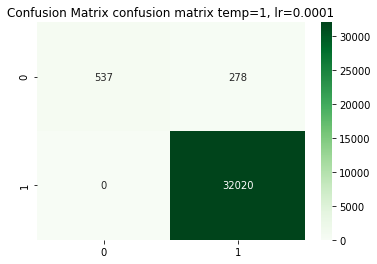

precision_score 0.9913926558920056
roc_auc_score-auc: 0.8294478527607362
roc_curve-fpr: [0.         0.34110429 1.        ]
roc_curve-tpr: [0. 1. 1.]


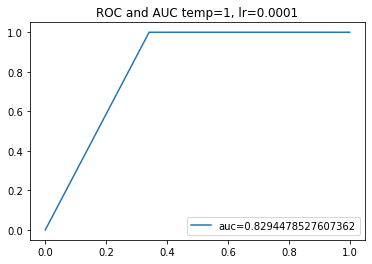

time :  0.7441670894622803
              precision    recall  f1-score   support

           0       0.69      1.00      0.81       466
           1       1.00      0.99      1.00     21790

    accuracy                           0.99     22256
   macro avg       0.84      0.99      0.90     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.9904295470884256
Precision: 0.990501441345643
Recall: 0.9904295470884256
F1 Score: 0.9895694662839475


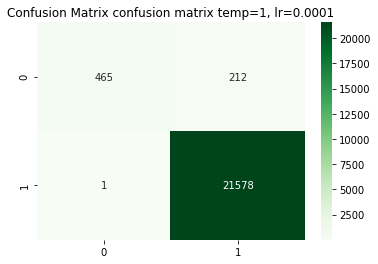

precision_score 0.9902698076258547
roc_auc_score-auc: 0.8434037126335215
roc_curve-fpr: [0.         0.31314623 1.        ]
roc_curve-tpr: [0.         0.99995366 1.        ]


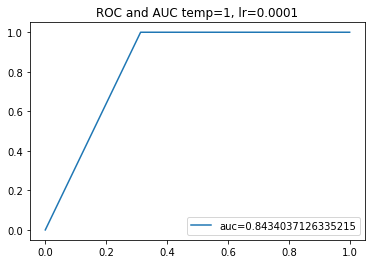

In [28]:
trained_student_model_t1, device = kd.train_multi_teachers_kd_param(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, num_epochs, model_path, "kd20epochs",
                                                1.0, 0.0001)
kd.predict(trained_student_model_t1, device, train_iter_kd, "distilbert", "temp=1, lr=0.0001", num_classes)
kd.predict(trained_student_model_t1, device, test_iter_kd, "distilbert", "temp=1, lr=0.0001", num_classes)

temp:0.1, lr:0.0001
epoch:  0 	 loss:  6.0373410788228625
epoch:  1 	 loss:  5.993433347674852
epoch:  2 	 loss:  5.796678132793886
epoch:  3 	 loss:  5.813259375995528
epoch:  4 	 loss:  5.71232499178717
epoch:  5 	 loss:  5.713231852899071
epoch:  6 	 loss:  5.681589577995965
epoch:  7 	 loss:  5.468189942942331
epoch:  8 	 loss:  5.4418639145746965
epoch:  9 	 loss:  5.366146989891718
time :  195.08041524887085
time :  1.1964845657348633
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       561
           1       1.00      0.99      1.00     32274

    accuracy                           0.99     32835
   macro avg       0.84      1.00      0.91     32835
weighted avg       0.99      0.99      0.99     32835

predicted label:  {0, 1}
Accuracy: 0.9922643520633471
Precision: 0.9923252324802743
Recall: 0.9922643520633471
F1 Score: 0.9915656589764171


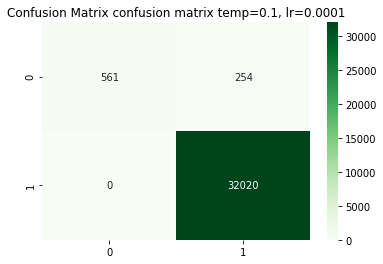

precision_score 0.9921298878354093
roc_auc_score-auc: 0.8441717791411043
roc_curve-fpr: [0.         0.31165644 1.        ]
roc_curve-tpr: [0. 1. 1.]


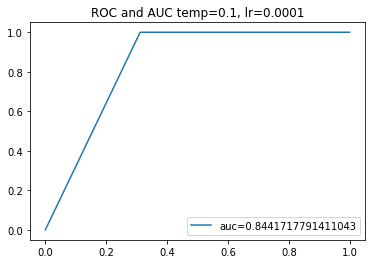

time :  0.7562034130096436
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       493
           1       1.00      0.99      1.00     21763

    accuracy                           0.99     22256
   macro avg       0.86      0.99      0.92     22256
weighted avg       0.99      0.99      0.99     22256

predicted label:  {0, 1}
Accuracy: 0.9916427030913012
Precision: 0.9916962121424004
Recall: 0.9916427030913012
F1 Score: 0.9910032877569815


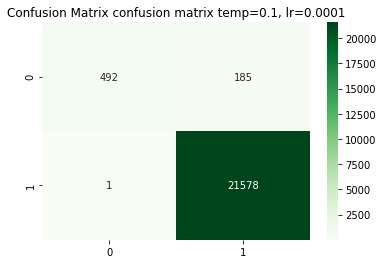

precision_score 0.9914983180173401
roc_auc_score-auc: 0.8633446284385436
roc_curve-fpr: [0.        0.2732644 1.       ]
roc_curve-tpr: [0.         0.99995366 1.        ]


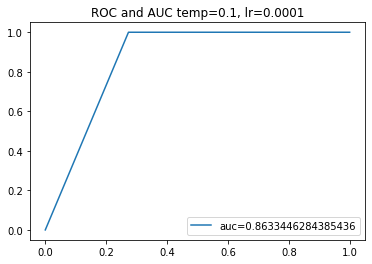

In [29]:
trained_student_model_t01, device = kd.train_multi_teachers_kd_param(student_model, teacher_models, 
                                                device, 
                                                train_iter_kd, num_epochs, model_path, "kd20epochs",
                                                0.1, 0.0001)
kd.predict(trained_student_model_t01, device, train_iter_kd, "distilbert", "temp=0.1, lr=0.0001", num_classes)
kd.predict(trained_student_model_t01, device, test_iter_kd, "distilbert", "temp=0.1, lr=0.0001", num_classes)

# Unmount and flush google drive

In [30]:
from google.colab import drive
drive.flush_and_unmount()